In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


In [ ]:
loan = pd.read_csv("LoanExport.csv", low_memory=False)

<AxesSubplot:>

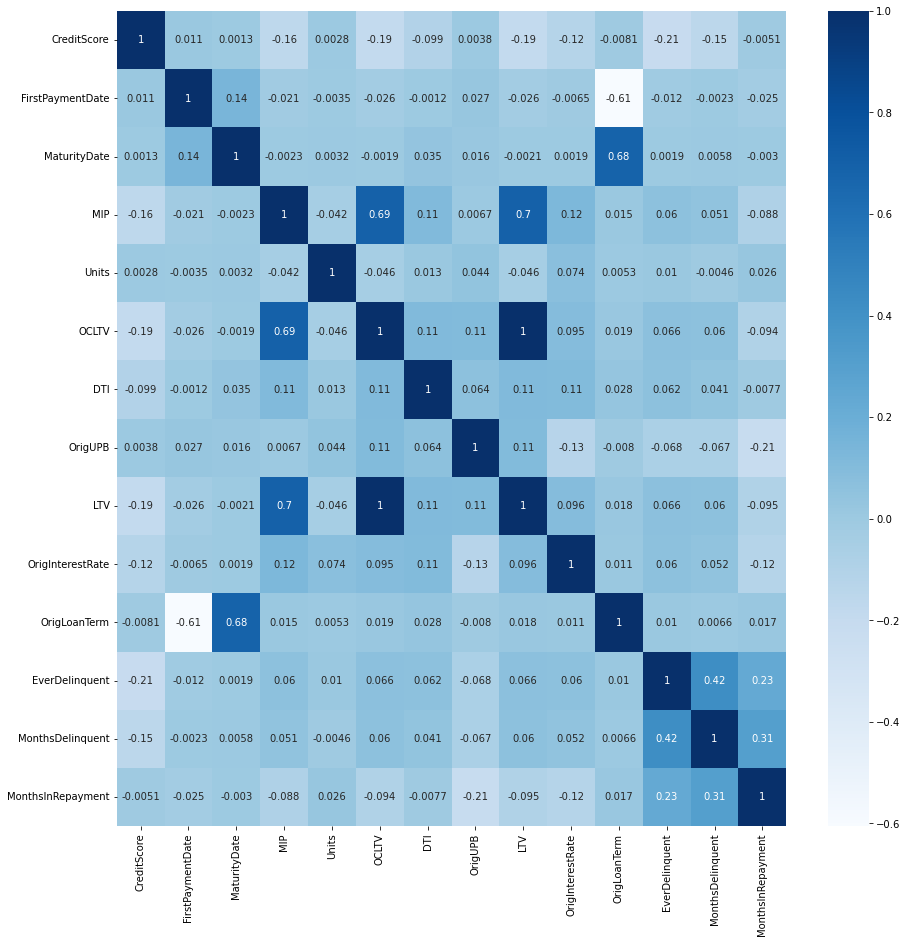

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(loan.corr(),cbar=True,annot=True,cmap='Blues')

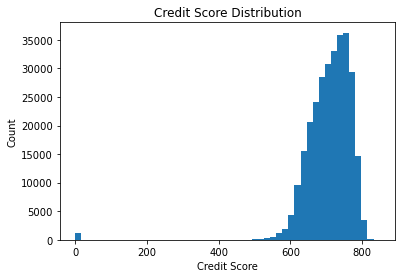

In [ ]:
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.hist(loan["CreditScore"], bins=50)
plt.show()

In [ ]:
def date_to_num(X):
  m = X%100
  y = ((X - m) / 100) - 1999
  return (m + (y * 12))

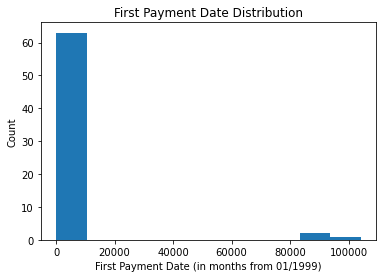

In [ ]:
plt.title('First Payment Date Distribution')
plt.xlabel('First Payment Date (in months from 01/1999)')
plt.ylabel('Count')
plt.hist(date_to_num(loan['FirstPaymentDate']).value_counts().sort_index())
plt.show()

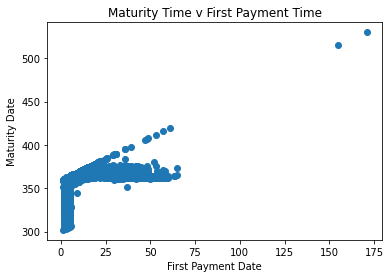

In [ ]:
# dataframe with two columns: first payment date and maturity date to visualize the relation using a scatterplot
first_pay_maturity = date_to_num(loan[['FirstPaymentDate', 'MaturityDate']])

plt.title('Maturity Time v First Payment Time')
plt.xlabel('First Payment Date')
plt.ylabel('Maturity Date')
plt.scatter(first_pay_maturity.iloc[:,0], first_pay_maturity.iloc[:,1])
plt.show()

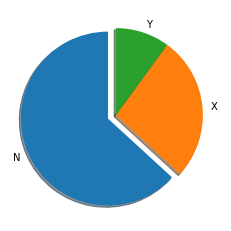

In [ ]:
plt.pie(loan['FirstTimeHomebuyer'].value_counts(), labels=loan['FirstTimeHomebuyer'].value_counts().index, shadow=True, explode=(0.1,0,0), startangle=90)
plt.show()

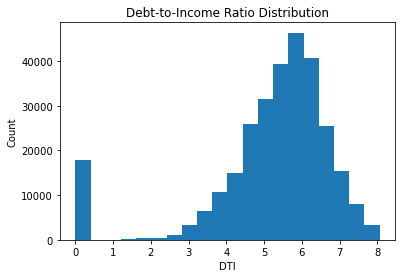

In [ ]:
# Debt-to-Income Ratio
plt.title('Debt-to-Income Ratio Distribution')
plt.xlabel('DTI')
plt.ylabel('Count')
plt.hist(np.sqrt(loan['DTI']), bins=20)
plt.show()

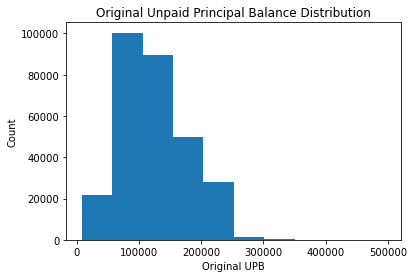

In [ ]:
# Original Unpaid Principal Balance
plt.title('Original Unpaid Principal Balance Distribution')
plt.xlabel('Original UPB')
plt.ylabel('Count')
plt.hist(loan['OrigUPB'])
plt.show()

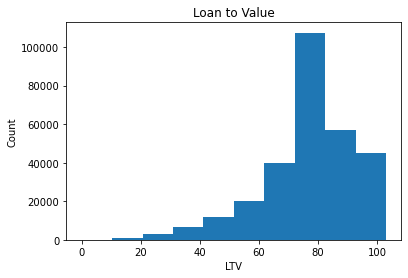

In [ ]:
# Loan to Value
plt.title('Loan to Value')
plt.xlabel('LTV')
plt.ylabel('Count')
plt.hist(loan['LTV'])
plt.show()

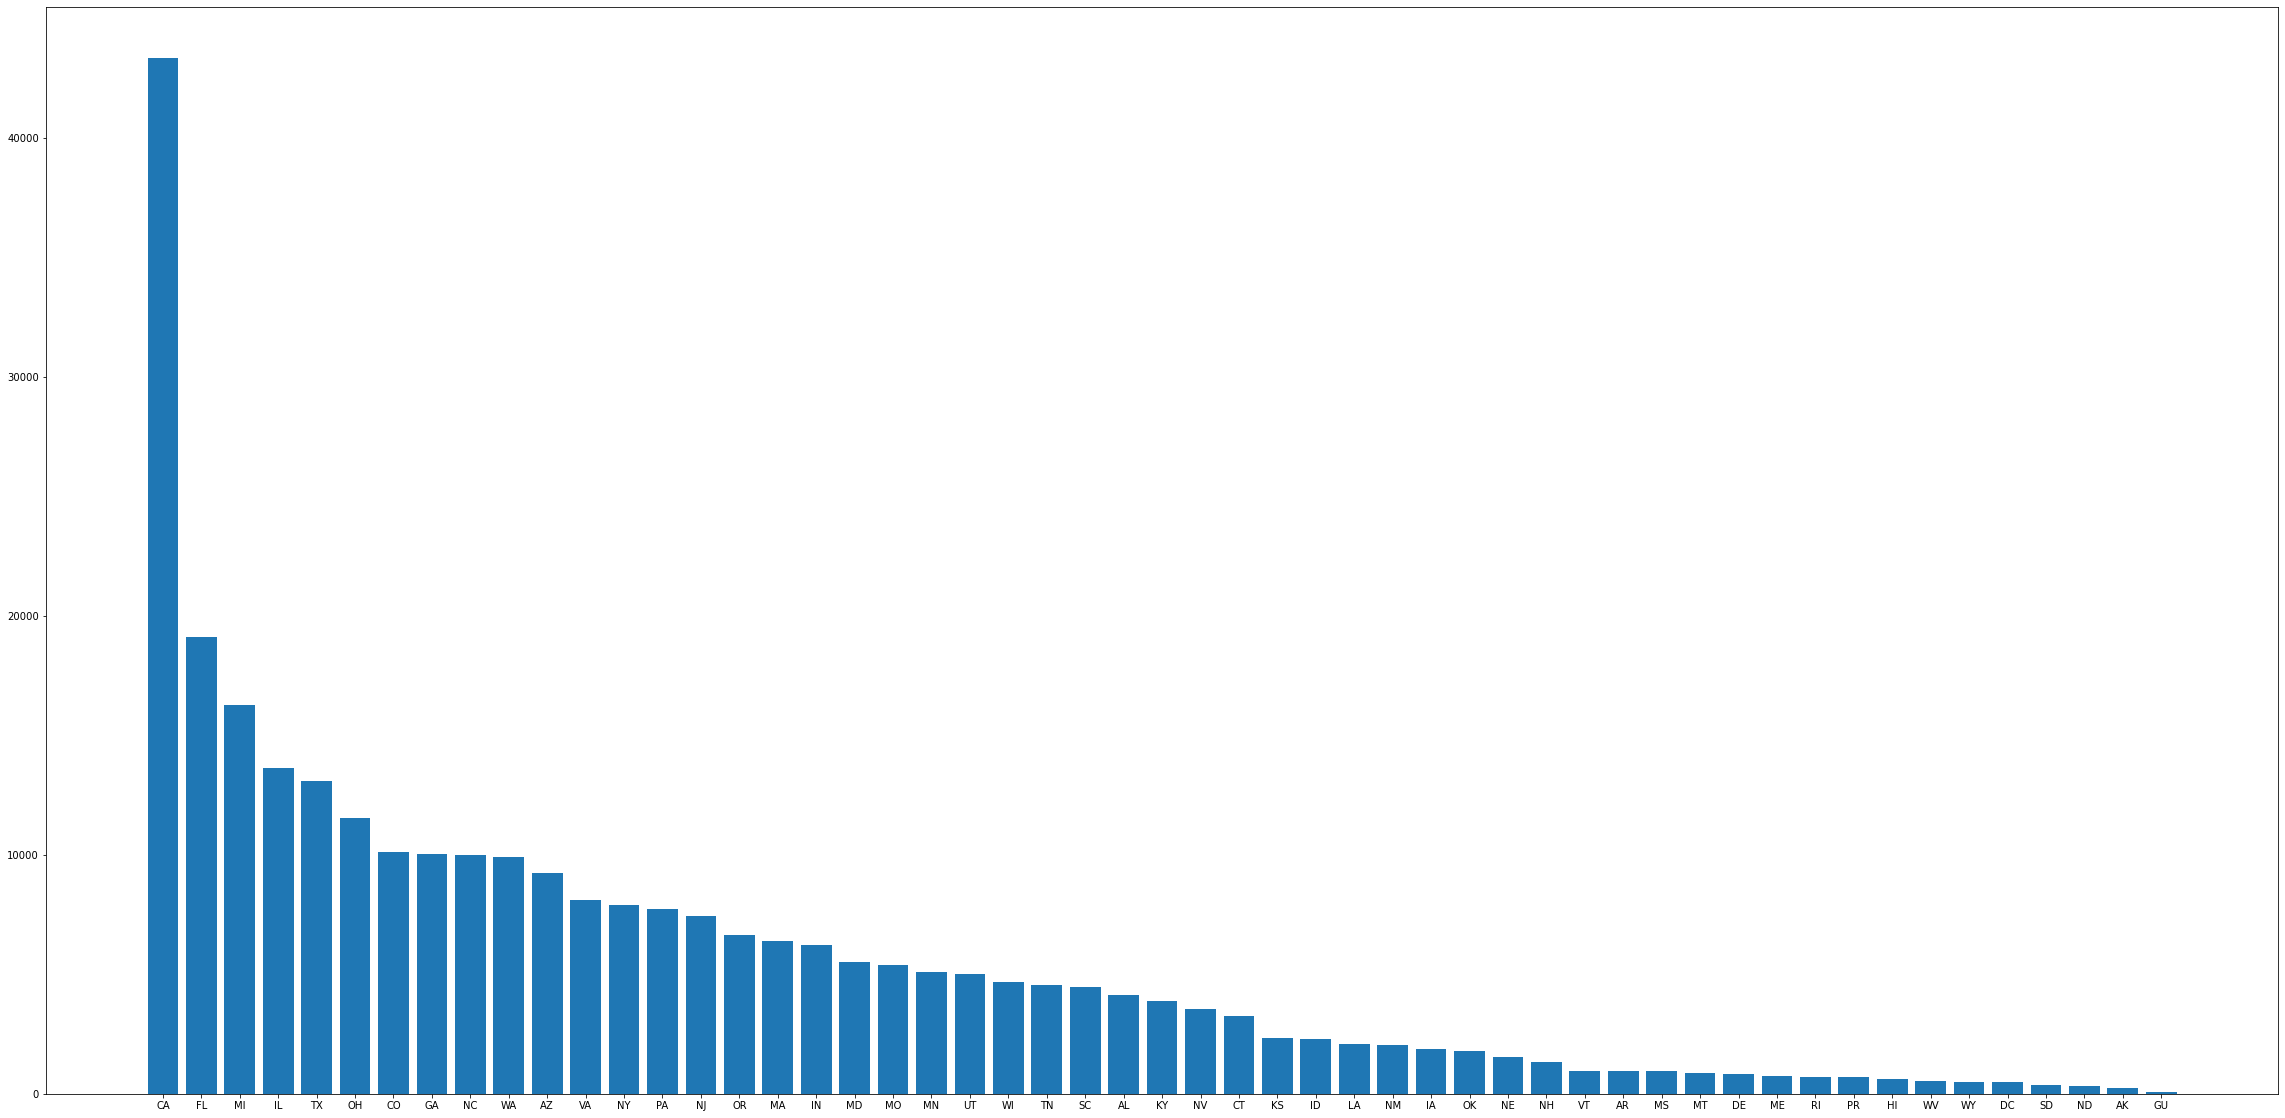

In [ ]:
plt.figure(figsize=(40,20))
plt.bar(loan['PropertyState'].value_counts().index, loan['PropertyState'].value_counts())
plt.show()

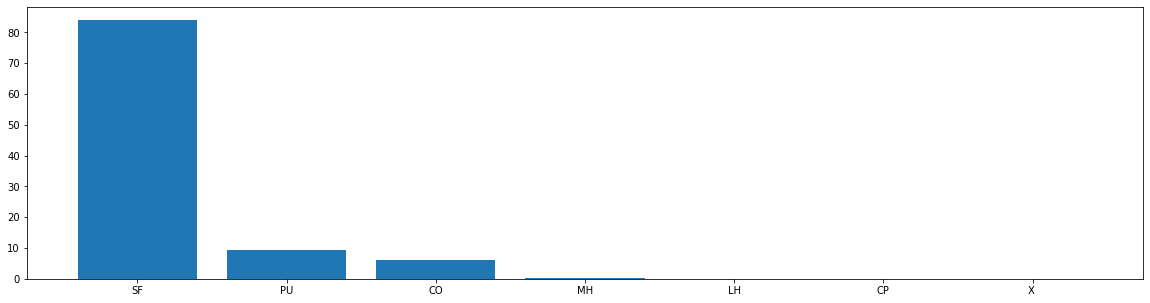

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(loan['PropertyType'].value_counts().index, loan['PropertyType'].value_counts()/len(loan['PropertyType']) * 100)
plt.show()

In [ ]:
loan['EverDelinquent'].value_counts()

0    233788
1     57663
Name: EverDelinquent, dtype: int64

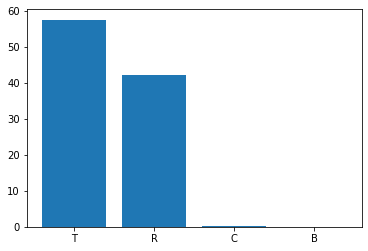

In [ ]:
plt.bar(loan['Channel'].value_counts().index, loan['Channel'].value_counts()/len(loan['Channel']) * 100)
plt.show()

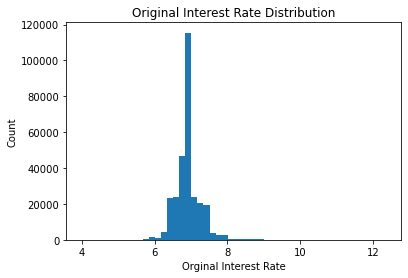

In [ ]:
plt.title('Original Interest Rate Distribution')
plt.xlabel('Orginal Interest Rate')
plt.ylabel('Count')
plt.hist(loan['OrigInterestRate'], bins=50)
plt.show()

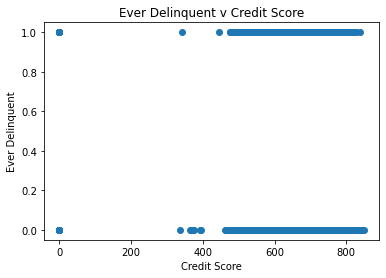

In [ ]:
plt.title('Ever Delinquent v Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Ever Delinquent')
plt.scatter(loan['CreditScore'], loan['EverDelinquent'])
plt.show()

In [ ]:
numeric = loan.select_dtypes(include=np.number)
numeric_cols = np.array(numeric.columns)
categorical_cols = np.setdiff1d(loan.columns, numeric_cols)
categorical_cols_to_plot = np.setdiff1d(categorical_cols, ['MSA', 'PropertyState'])

In [ ]:
fig,ax = plt.subplots(2,4,figsize=(30,18))
for axi,x in zip(ax.flat, categorical_cols_to_plot):
    sns.countplot(x=loan.EverDelinquent,hue=loan[x],ax=axi)

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# do not modify train, test
train, test = train_test_split(loan, test_size=0.2, random_state=36)

### Feature Engineering

In [ ]:
# work with df going forward
df = train.copy()
df_test = test.copy()

In [ ]:
# TRANSFORMATION PIPELINE 2
# To drop unnecessary columns and rows with missing values
def drop_pipeline_1(X):
    # DROP: drop the rows with FirstTimeHomebuyer == 'X'
    # Note: also try imputing with KNNImputer
    unk_cols = list(X[X['FirstTimeHomebuyer']=='X'].index)
    X.drop(unk_cols,axis=0,inplace=True)
    return X
    
# TRANSFORMATION PIPELINE 1
def correction_pipeline(X):
    # Credit Score 0 is actually 850,so convert all 0s to 850
    X.loc[:,'CreditScore'] = np.where(X.loc[:,'CreditScore'] == 0, 850, X.loc[:,'CreditScore'])
    return X
    

# TRANSFORMATION PIPELINE 4
def drop_pipeline_2(X):
    # MonthsDelinquent should not be available, or the problem is a trivial hard-programmable problem rather than a ML problem
    X.drop(['MonthsDelinquent','LoanPurpose','PropertyType','SellerName','ServicerName','PostalCode','LoanSeqNum','MonthsInRepayment','CreditScore','LTV','FirstPaymentDate', 'MaturityDate','MSA','Occupancy','Channel','PPM','ProductType','PropertyState','NumBorrowers'],axis=1,inplace=True)
#     X.drop(['LoanPurpose','PropertyType','SellerName','ServicerName','PostalCode','LoanSeqNum','MonthsInRepayment','CreditScore','LTV','FirstPaymentDate', 'MaturityDate','MSA','Occupancy','Channel','PPM','ProductType','PropertyState','NumBorrowers'],axis=1,inplace=True)
    return X

numeric = df.select_dtypes(include=np.number)

numeric_cols = np.array(numeric.columns)

categorical = df.drop(numeric_cols, axis=1)

# TRANSFORMATION PIPELINE 3
def num_to_cat(X):
    X['CreditRange'] = pd.cut(X.CreditScore,[0,550,650,700,750,1e9],labels=[1,2,3,4,5], include_lowest=True)
    X['LTVRange'] = pd.cut(X.LTV,[0,25,50,1000],labels=['Low','Medium','High'], include_lowest=True)
    X['RepayRange'] = pd.cut(X.MonthsInRepayment,[0,48,96,144,192,240],
                           labels=['0-4yrs','4-8yrs','8-12yrs', '12-16yrs', '16-20yrs'])
    X = X.rename(columns = {'FirstTimeHomebuyer':'IsFirstTime'})
    # Y/N to 1/0
    X['IsFirstTime'] = np.where(X['IsFirstTime'] == 'Y', 1, 0)
    return X

# TRANSFORMATION PIPELINE 5
def reorder_cols(X):
    cols = list(X.columns)
    cols.remove('EverDelinquent')
    cols.append('EverDelinquent')
    print(cols)
    return X.loc[:,cols]

### Encoding and Feature Scaling Pipeline

In [ ]:
def transform(X):
    return reorder_cols(drop_pipeline_2(num_to_cat(drop_pipeline_1(correction_pipeline(X)))))

In [ ]:
df = transform(df)
df_test = transform(df_test)

['IsFirstTime', 'MIP', 'Units', 'OCLTV', 'DTI', 'OrigUPB', 'OrigInterestRate', 'OrigLoanTerm', 'CreditRange', 'LTVRange', 'RepayRange', 'EverDelinquent']
['IsFirstTime', 'MIP', 'Units', 'OCLTV', 'DTI', 'OrigUPB', 'OrigInterestRate', 'OrigLoanTerm', 'CreditRange', 'LTVRange', 'RepayRange', 'EverDelinquent']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170954 entries, 20372 to 222110
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   IsFirstTime       170954 non-null  int32   
 1   MIP               170954 non-null  int64   
 2   Units             170954 non-null  int64   
 3   OCLTV             170954 non-null  int64   
 4   DTI               170954 non-null  int64   
 5   OrigUPB           170954 non-null  int64   
 6   OrigInterestRate  170954 non-null  float64 
 7   OrigLoanTerm      170954 non-null  int64   
 8   CreditRange       170954 non-null  category
 9   LTVRange          170954 non-null  category
 10  RepayRange        170954 non-null  category
 11  EverDelinquent    170954 non-null  int64   
dtypes: category(3), float64(1), int32(1), int64(7)
memory usage: 12.9 MB


In [ ]:
df.head()

,IsFirstTime,MIP,Units,OCLTV,DTI,OrigUPB,OrigInterestRate,OrigLoanTerm,CreditRange,LTVRange,RepayRange,EverDelinquent
20372,0,25,1,90,29,79000,6.75,360,2,High,12-16yrs,1
117611,0,0,1,76,46,95000,6.75,360,4,High,4-8yrs,0
56509,0,25,1,90,50,164000,6.75,360,3,High,0-4yrs,0
239655,0,0,1,80,26,113000,6.75,360,5,High,8-12yrs,1
27560,0,30,1,95,37,83000,7.75,360,2,High,0-4yrs,0


In [ ]:
column_names = df.columns
column_names = list(column_names)
column_names.pop()

'EverDelinquent'

In [ ]:
column_names

['IsFirstTime',
 'MIP',
 'Units',
 'OCLTV',
 'DTI',
 'OrigUPB',
 'OrigInterestRate',
 'OrigLoanTerm',
 'CreditRange',
 'LTVRange',
 'RepayRange']

### Feature Selection

### Mutual Information Score

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
def make_mi_scores(X, Y):
    X = X.copy()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
#     discrete_features = ['IsFirstTime', 'MIP', 'Units','OCLTV','DTI','OrigUPB','OrigLoanTerm']
    mi_scores = mutual_info_classif(X, Y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()

df_feat_select = df.copy()
df_feat_select['RepayRange']=lab.fit_transform(df_feat_select['RepayRange'])
df_feat_select['LTVRange']=lab.fit_transform(df_feat_select['LTVRange'])
df_feat_select['CreditRange']=lab.fit_transform(df_feat_select['CreditRange'])

mi_scores = make_mi_scores(df_feat_select.iloc[:,:-1], df_feat_select.iloc[:,-1])
print(mi_scores)

CreditRange         0.031623
RepayRange          0.022100
OrigInterestRate    0.005324
OrigUPB             0.003701
OCLTV               0.003242
MIP                 0.002552
DTI                 0.001861
LTVRange            0.000880
OrigLoanTerm        0.000313
Units               0.000079
IsFirstTime         0.000019
Name: MI Scores, dtype: float64


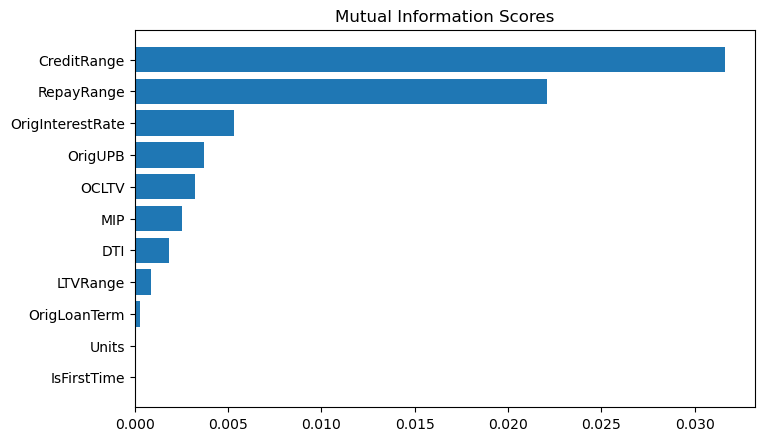

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### Extra Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,criterion ='entropy', max_features = 2)                                 
extra_tree_forest.fit(df_feat_select.iloc[:,:-1], df_feat_select.iloc[:,-1])
feature_importance = extra_tree_forest.feature_importances_ 
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_],
                                        axis = 0)

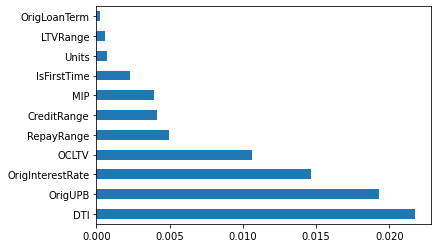

In [ ]:
feat_importances=pd.Series(feature_importance_normalized, index=df_feat_select.iloc[:,:-1].columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

### Creating final X_train, y_train, X_test, y_test

In [ ]:
y_train = df.iloc[:,-1]
X_train = df.iloc[:,:-1]

cat_cols = ['CreditRange','LTVRange','RepayRange']
num_cols = np.setdiff1d(X_train.columns, cat_cols)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = make_pipeline(OneHotEncoder())
num_pipeline = make_pipeline(StandardScaler())

from sklearn.compose import ColumnTransformer
encode_scale = ColumnTransformer([
    ("OneHotEncoder",cat_pipeline,cat_cols),
    ("Scaler",num_pipeline,num_cols),
])

In [ ]:
X_train = encode_scale.fit_transform(X_train)

In [ ]:
X_train

array([[ 0.        ,  1.        ,  0.        , ...,  0.07220754,
        -0.86862182, -0.12321047],
       [ 0.        ,  0.        ,  0.        , ...,  0.07220754,
        -0.57053241, -0.12321047],
       [ 0.        ,  0.        ,  1.        , ...,  0.07220754,
         0.71497815, -0.12321047],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.07220754,
         0.43551933, -0.12321047],
       [ 0.        ,  0.        ,  0.        , ...,  0.07220754,
         0.26784404, -0.12321047],
       [ 0.        ,  0.        ,  0.        , ...,  0.07220754,
        -0.81273005, -0.12321047]])

In [ ]:
y_test = df_test.iloc[:,-1]
X_test = df_test.iloc[:,:-1]
X_test = encode_scale.fit_transform(X_test)

In [ ]:
y_train.value_counts()

0    137631
1     33323
Name: EverDelinquent, dtype: int64

In [ ]:
# you can use this function to convert the preprocessed train set from type ndarray to DataFrame
def convert_to_df(X):
    return pd.DataFrame(X, columns=encode_scale.get_feature_names_out())

### SUPPORT VETOR CLASSIFIER

In [ ]:
from sklearn import svm

In [ ]:
#create a classifier
cls = svm.SVC(kernel="linear")

In [ ]:
#train the model
cls.fit(X_train,y_train)

SVC(kernel='linear')

In [ ]:
#predict the response
pred = cls.predict(X_test)

In [ ]:
from sklearn import metrics
#accuracy
print("acuracy:", metrics.accuracy_score(y_test,y_pred=pred))
#precision score
print("precision:", metrics.precision_score(y_test,y_pred=pred))
#recall score
print("recall" , metrics.recall_score(y_test,y_pred=pred))
print(metrics.classification_report(y_test, y_pred=pred))

acuracy: 0.8042935831646344
precision: 0.5077208153180975
recall 0.0985729703801415
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     34143
           1       0.51      0.10      0.17      8339

    accuracy                           0.80     42482
   macro avg       0.66      0.54      0.53     42482
weighted avg       0.76      0.80      0.75     42482

